In [44]:
import pandas as pd
import numpy as np
# Read the CSV file
df = pd.read_csv('C:\\Users\\37424\\Desktop\\simulated_transaction_2024.csv')
pd.set_option('display.float_format', lambda x: '%.0f' % x)
# print(df.head().to_string(index=False))

In [45]:
# Check for any missing values
print(df.isnull().sum())

Date                         229
Timestamp                    251
Account No                   224
Balance                      246
Amount                       209
Third Party Account No    223764
Third Party Name            7079
dtype: int64


In [46]:
# # Replace empty strings with NaN
# df['Date'].replace('', pd.NA, inplace=True)
#
# # Find the index of the first row with a missing 'Date'
# first_missing_date_index = df[df['Date'].isnull()].index.min()
#
# # Get the row with the first missing 'Date'
# if pd.notna(first_missing_date_index):
#     first_missing_date_row = df.loc[first_missing_date_index]
# else:
#     first_missing_date_row = "No missing Date found"
#
# # Display the row with the first missing 'Date'
# print(first_missing_date_row)

In [47]:
# Define the condition for rows to drop
condition = (
    df['Date'].isnull() |
    df['Timestamp'].isnull() |
    df['Account No'].isnull() |
    df['Balance'].isnull() |
    df['Amount'].isnull() |
    (df['Third Party Account No'].isnull() & df['Third Party Name'].isnull())
)

# Invert the condition to keep rows where the condition is False
df_cleaned = df[~condition]
print(df_cleaned.head().to_string(index=False))
df_cleaned.to_csv('New_dataset_clean.csv', index=False)

      Date Timestamp  Account No  Balance  Amount  Third Party Account No   Third Party Name
01/01/2023     00:00   678330503     2971    1584                     NaN Westport Care Home
01/01/2023     00:00   472213568     3792    1950                     NaN   Barbiee Boutique
01/01/2023     00:00   472213568     3012    -780               283027736                NaN
01/01/2023     00:00   283027736     1787     780               472213568                NaN
01/01/2023     00:00   624500124     3226    1825                     NaN           Fat Face


In [48]:
print(df_cleaned.isnull().sum())

Date                           0
Timestamp                      0
Account No                     0
Balance                        0
Amount                         0
Third Party Account No    222389
Third Party Name            6805
dtype: int64


In [49]:
unique_account_nos = df_cleaned['Account No'].nunique()
print(f"Unique Account Nos: {unique_account_nos}")

unique_third_party_names = df_cleaned['Third Party Name'].replace('', np.nan).nunique()
print(f"Unique Third Party Names: {unique_third_party_names}")

Unique Account Nos: 976
Unique Third Party Names: 83


In [50]:
df_cleaned = df_cleaned.copy()
# Convert the 'Date' and 'Timestamp' columns to a single datetime column
df_cleaned['Datetime'] = pd.to_datetime(df_cleaned['Date'] + ' ' + df_cleaned['Timestamp'], format="%d/%m/%Y %H:%M")

# Sort the data by 'Account No' and 'Datetime'
sorted_data = df_cleaned.sort_values(by=['Account No', 'Datetime'])
sorted_data = sorted_data.drop(columns=['Date', 'Timestamp'])
print(sorted_data.head(1000).to_string(index=False))
sorted_data.to_csv('New_dataset_Account_with_datetime.csv', index=False)


 Account No  Balance  Amount  Third Party Account No  Third Party Name            Datetime
  101531259      124    -859                     NaN               LBG 2023-01-01 00:00:00
  101531259      116      -8                     NaN            Disney 2023-01-01 00:00:00
  101531259       16    -100                     NaN   Grand Union BJJ 2023-01-01 00:00:00
  101531259      -64     -80                     NaN           Matalan 2023-01-01 09:37:00
  101531259     -248    -184                     NaN           Matalan 2023-01-01 12:00:00
  101531259     -446    -198                     NaN           Topshop 2023-01-01 12:28:00
  101531259     -550    -104                     NaN           Matalan 2023-01-01 15:54:00
  101531259     -650    -100                     NaN           Topshop 2023-01-01 16:28:00
  101531259     -778    -128                     NaN           Matalan 2023-01-01 16:52:00
  101531259     -872     -93                     NaN             Tesco 2023-01-07 08:38:00

In [51]:
sorted_data_with_acc = sorted_data.dropna(subset=['Third Party Account No'])
print(sorted_data_with_acc.head(1000).to_string(index=False))
sorted_data_with_acc.to_csv('New_dataset_Account_with_Account.csv', index=False)

 Account No  Balance  Amount  Third Party Account No Third Party Name            Datetime
  104832000     2385    -670               587923845              NaN 2023-01-01 00:00:00
  104832000     1072    -670               587923845              NaN 2023-01-31 23:59:00
  104832000       51     290               587923845              NaN 2023-02-15 06:57:00
  104832000      600    -670               587923845              NaN 2023-02-28 23:59:00
  104832000      128    -670               587923845              NaN 2023-03-31 23:59:00
  104832000     -370    -670               587923845              NaN 2023-04-30 23:59:00
  104832000    -1212     160               587923845              NaN 2023-05-02 12:18:00
  104832000     -734    -670               587923845              NaN 2023-05-31 23:59:00
  104832000     -999    -670               587923845              NaN 2023-06-30 23:59:00
  104832000    -1229    -670               587923845              NaN 2023-07-31 23:59:00
  10483200

In [52]:
#Determine transaction type (expenditure or income)
sorted_data['Transaction Type'] = sorted_data['Amount'].apply(lambda x: 'Expense' if x < 0 else 'Income')

#Group by month and account
sorted_data['Month'] = sorted_data['Datetime'].dt.to_period('M')
grouped_data = sorted_data.groupby(['Account No', 'Month'])

monthly_expense = grouped_data['Amount'].agg(lambda x: x[x < 0].sum()).rename('Monthly Expense')
monthly_income = grouped_data['Amount'].agg(lambda x: x[x > 0].sum()).rename('Monthly Income')
monthly_balance = grouped_data['Balance'].agg('last').rename('End of Month Balance')

#Merge Results
monthly_summary = pd.concat([monthly_expense, monthly_income, monthly_balance], axis=1)
monthly_summary.columns = ['Monthly Expense', 'Monthly Income', 'End of Month Balance']
monthly_summary.reset_index(inplace=True)

print(monthly_summary.head(1000).to_string(index=False))
monthly_summary.to_csv('New_dataset_Account_monthly_summary.csv', index=False)

 Account No   Month  Monthly Expense  Monthly Income  End of Month Balance
  101531259 2023-01            -2241            1542                  -575
  101531259 2023-02            -1223            1542                  -311
  101531259 2023-03            -1146            1542                    85
  101531259 2023-04            -1411            1542                   217
  101531259 2023-05            -1369            1542                   390
  101531259 2023-06            -1881            1542                    13
  101531259 2023-07            -1221            1542                   334
  101531259 2023-08            -1854            1542                    22
  101531259 2023-09            -1251            1542                   314
  101531259 2023-10            -1771            1542                    85
  101531259 2023-11            -1239            1542                   389
  101531259 2023-12            -1020               0                   228
  104832000 2023-01      

In [53]:
sorted_data['Year'] = sorted_data['Datetime'].dt.year

grouped_data = sorted_data.groupby(['Account No', 'Year'])

annual_expense = grouped_data['Amount'].apply(lambda x: x[x < 0].sum()).rename('Annual Expense')
annual_income = grouped_data['Amount'].apply(lambda x: x[x > 0].sum()).rename('Annual Income')

annual_balance = grouped_data['Balance'].apply(lambda x: x.iloc[-1]).rename('End of Year Balance')

annual_summary = pd.concat([annual_expense, annual_income, annual_balance], axis=1).reset_index()
print(annual_summary.head(1000).to_string(index=False))
annual_summary.to_csv('New_dataset_Account_annual_summary.csv', index=False)

 Account No  Year  Annual Expense  Annual Income  End of Year Balance
  101531259  2023          -17628          16968                  228
  104832000  2023          -25116          20550                -3186
  105375973  2023          -10067           9000                  509
  106601471  2023           -7760          18425                11920
  108481285  2023          -15062          25104                10704
  108563213  2023          -16494          41239                26334
  108812033  2023           -9641           9130                  717
  108931112  2023          -38492          53519                16503
  111137699  2023          -21787          20100                  -80
  113747882  2023          -16187          28425                13639
  116169597  2023          -17933          19218                 1790
  116598243  2023          -21076          22872                 3634
  117273481  2023          -26986          37136                10922
  117308635  2023   

In [54]:
df_with_third_party = sorted_data.dropna(subset=['Third Party Name'])
df_with_third_party.loc[:,'Transaction Type'] = df_with_third_party['Amount'].apply(lambda x: 'Expense' if x > 0 else 'Income')

# Group by 'Third Party Name' and sort within each group by 'Datetime'
grouped = df_with_third_party.groupby('Third Party Name').apply(lambda x: x.sort_values('Datetime'))

# Resetting index to get a clean dataframe
grouped = grouped.reset_index(drop=True)

# Reorder columns to have 'Third Party Name' as the first column
cols = grouped.columns.tolist()
cols.insert(0, cols.pop(cols.index('Third Party Name')))
grouped = grouped[cols]

# Remove 'Third Party Account No', 'Month' and 'Year' columns
columns_to_drop = ['Third Party Account No', 'Month', 'Year']
grouped = grouped.drop(columns_to_drop, axis=1)
# Displaying the sorted dataframe
print(grouped.head(3000).to_string(index=False))
grouped.to_csv('New_dataset_Merchant_corresponding_user_details.csv', index=False)

C:\Users\37424\AppData\Local\Temp\ipykernel_16740\3266552187.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_with_third_party.groupby('Third Party Name').apply(lambda x: x.sort_values('Datetime'))


Third Party Name  Account No  Balance  Amount            Datetime Transaction Type
     A Cut Above   285873880     3818    1950 2023-01-01 00:00:00          Expense
     A Cut Above   137822385     3625    2773 2023-01-01 00:00:00          Expense
     A Cut Above   768271776     3620    1950 2023-01-01 00:00:00          Expense
     A Cut Above   873701090     2357    1544 2023-01-01 00:00:00          Expense
     A Cut Above   865748375     4607    2773 2023-01-01 00:00:00          Expense
     A Cut Above   691789577     2533    2021 2023-01-01 00:00:00          Expense
     A Cut Above   819515373     3802    2021 2023-01-01 00:00:00          Expense
     A Cut Above   834383043     3939    2021 2023-01-01 00:00:00          Expense
     A Cut Above   675398089     1948    1244 2023-01-01 00:00:00          Expense
     A Cut Above   170637730     3178    2021 2023-01-01 00:00:00          Expense
     A Cut Above   768271776     2267    1950 2023-02-01 00:00:00          Expense
    

In [55]:
grouped2 = grouped[grouped['Transaction Type'] == 'Income']
grouped2['Third Party Name'] = grouped2['Third Party Name'].str.lower()
print(grouped2.head(1000).to_string(index=False))
grouped2.to_csv('New_dataset_Merchant_corresponding_incomes.csv', index=False)

C:\Users\37424\AppData\Local\Temp\ipykernel_16740\1320912043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped2['Third Party Name'] = grouped2['Third Party Name'].str.lower()


Third Party Name  Account No  Balance  Amount            Datetime Transaction Type
     a cut above   104832000    -2441    -200 2023-08-08 15:37:00           Income
    a yarn story   969804197      814     -44 2023-01-01 12:19:00           Income
    a yarn story   441142605     1182      -8 2023-01-02 09:38:00           Income
    a yarn story   687135796     1059     -27 2023-01-04 11:15:00           Income
    a yarn story   263882093      440     -38 2023-01-04 15:17:00           Income
    a yarn story   441142605     1120      -6 2023-01-04 16:17:00           Income
    a yarn story   496674181      534      -6 2023-01-05 17:42:00           Income
    a yarn story   993039226       85     -36 2023-01-06 16:23:00           Income
    a yarn story   822135975     3692      -3 2023-01-08 11:07:00           Income
    a yarn story   993039226      -19     -72 2023-01-09 16:04:00           Income
    a yarn story   699139822     2469     -48 2023-01-11 09:28:00           Income
    

In [56]:
current_date = grouped2['Datetime'].max()

rfm = grouped2.groupby(['Third Party Name', 'Account No']).agg({
    'Datetime': lambda x: (current_date - x.max()).days,  # Recency
    'Account No': 'count',                                        # Frequency
    'Amount': lambda x: -x.sum()                                    # Monetary
}).rename(columns={
    'Datetime': 'recency',
    'Account No': 'frequency',
    'Amount': 'monetary'
}).reset_index()


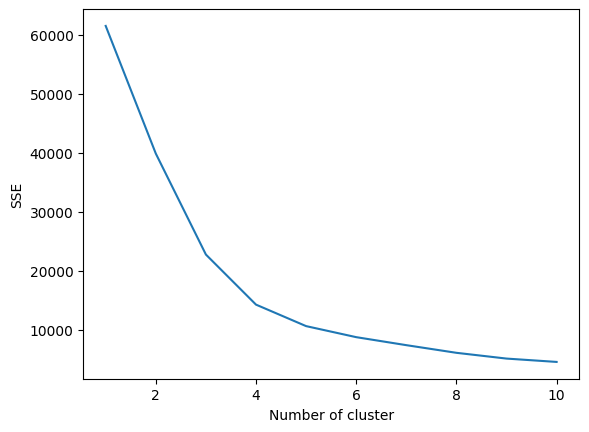

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#Perform independent clustering analysis on each merchant
# for account in rfm['to_randomly_generated_account'].unique():
#     print(f"Processing account: {account}")

#Filter data for specific merchants
# account_rfm = rfm[rfm['to_randomly_generated_account'] == account]

#Data preprocessing - Standardized RFM values
scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(account_rfm[['r_score', 'f_score', 'm_score']])
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])
#Initialize SSE dictionary to store SSE for each k value
sse = {}

#Use Elbow Method to find the optimal K value and test K values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_  # 存储SSE (Sum of Squared Errors)

#Draw a graph of SSE changing with k value
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel(f"Number of cluster for account {account}")
plt.xlabel(f"Number of cluster")
plt.ylabel("SSE")
plt.show()

#Select the optimal K value based on the graph
#
# k_opt = 3  #This value is the inflection point value in the elbow diagram
#
# #Applying K-Means clustering
# kmeans = KMeans(n_clusters=k_opt, random_state=42)
# clusters = kmeans.fit_predict(rfm_scaled)
# rfm['Cluster'] = clusters
#
# rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

Processing account: a cut above
Not enough unique data points to perform Elbow Method for account a cut above.
Processing account: a yarn story


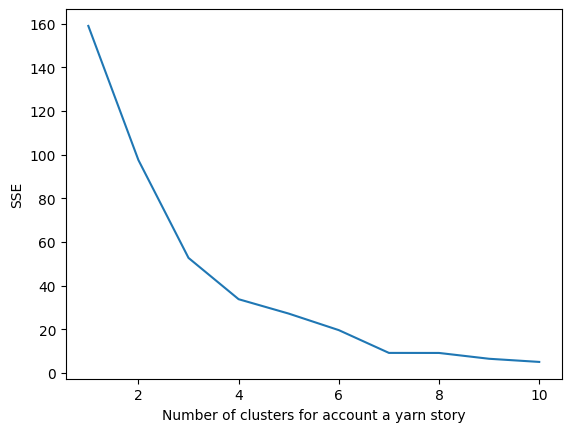

Merchant a yarn story optimal k value is: 3
Processing account: amazon


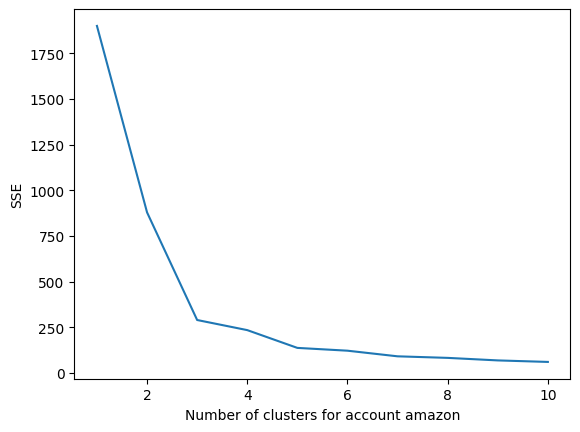

Merchant amazon optimal k value is: 3
Processing account: barbiee boutique
Not enough unique data points to perform Elbow Method for account barbiee boutique.
Processing account: blackwell's


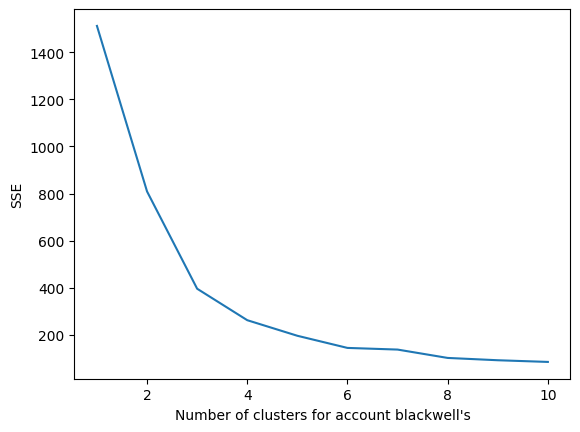

Merchant blackwell's optimal k value is: 3
Processing account: blizzard


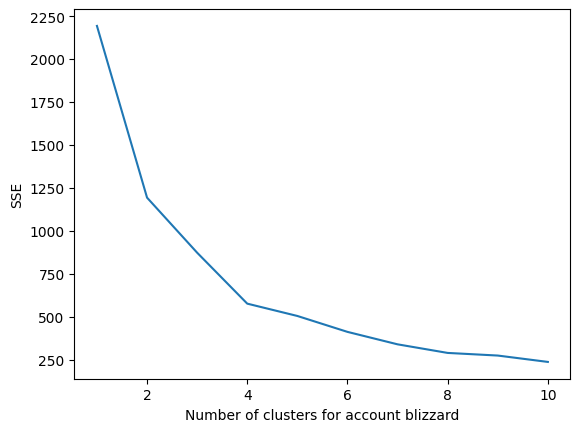

Merchant blizzard optimal k value is: 3
Processing account: boots


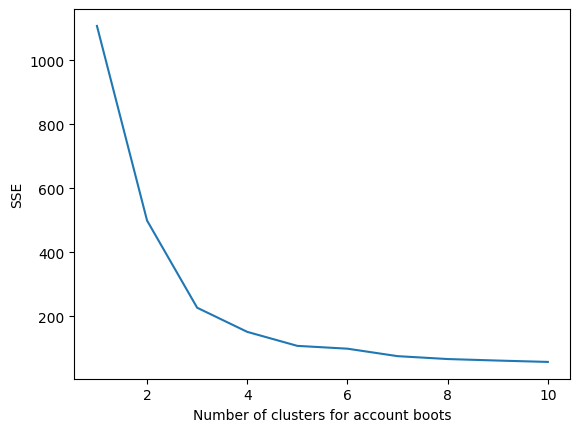

Merchant boots optimal k value is: 3
Processing account: brilliant brushes


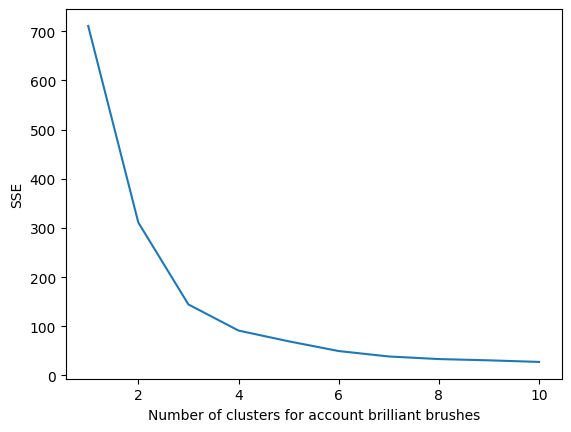

Merchant brilliant brushes optimal k value is: 3
Processing account: cass art


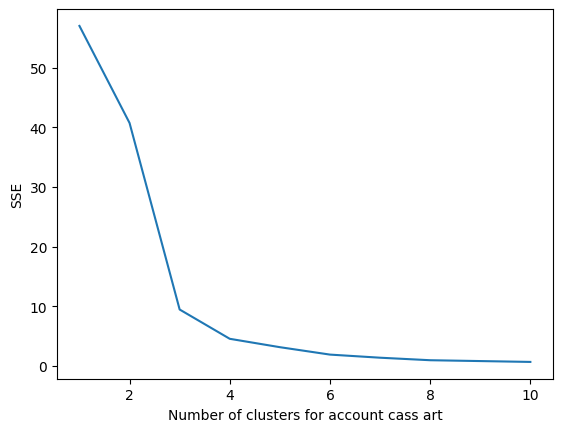

Merchant cass art optimal k value is: 4
Processing account: cex


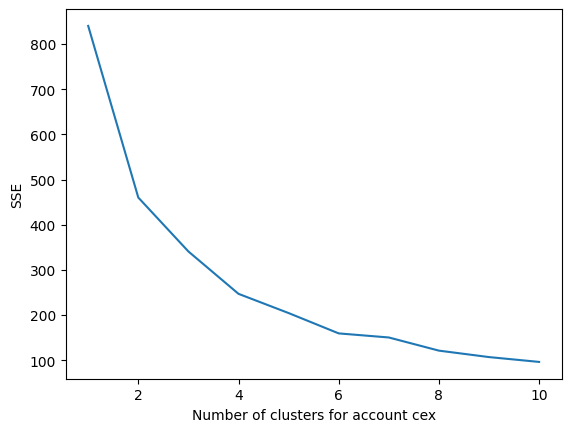

Merchant cex optimal k value is: 3
Processing account: coffee #1


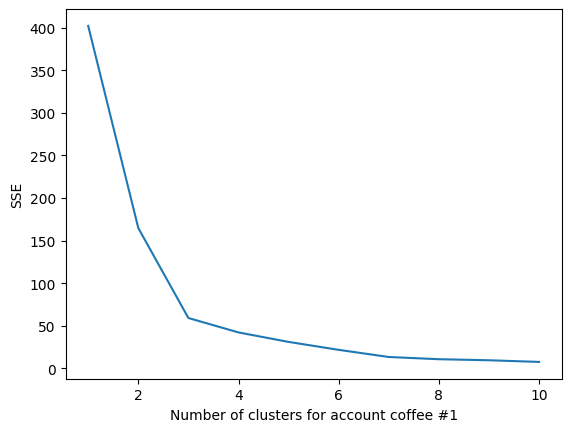

Merchant coffee #1 optimal k value is: 3
Processing account: collector cave


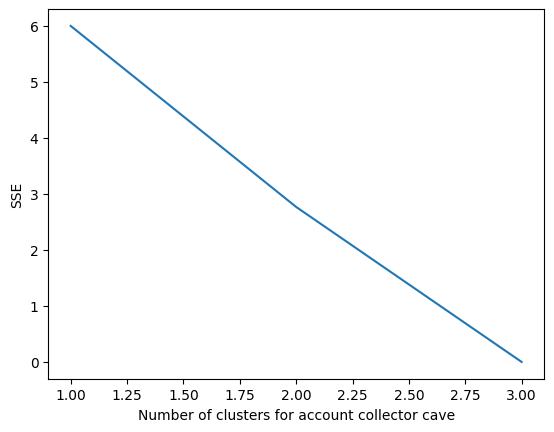

Merchant collector cave optimal k value is: 3
Processing account: coop local


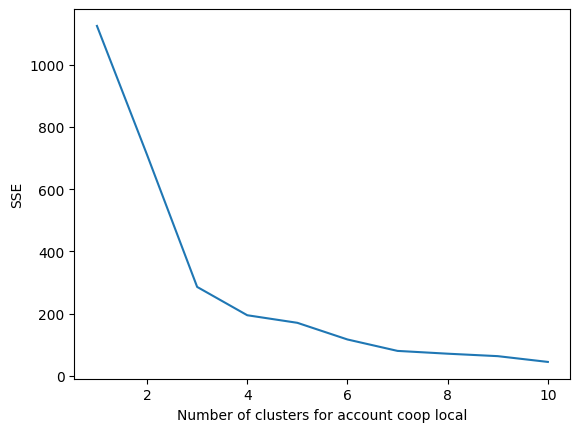

Merchant coop local optimal k value is: 4
Processing account: costa coffee


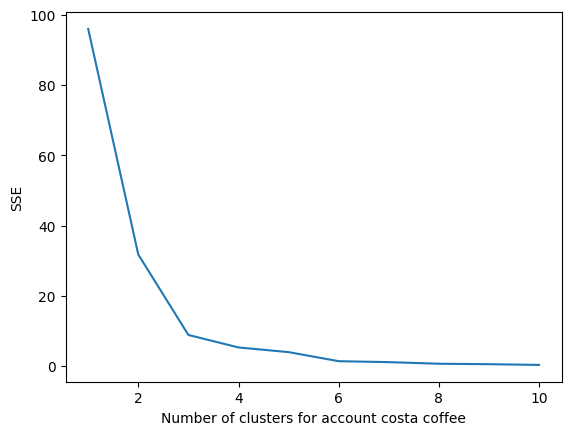

Merchant costa coffee optimal k value is: 3
Processing account: craftastic


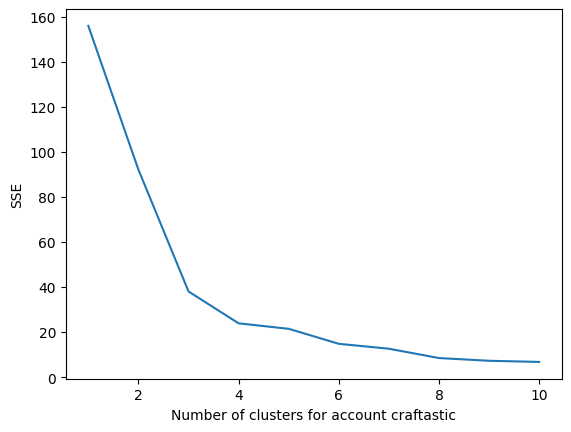

Merchant craftastic optimal k value is: 3
Processing account: deliveroo


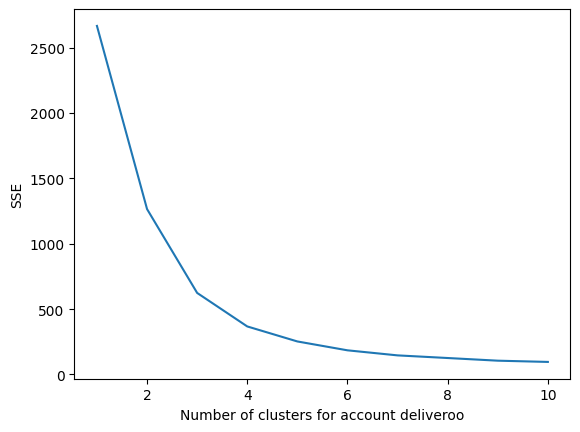

Merchant deliveroo optimal k value is: 3
Processing account: disney


D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklear

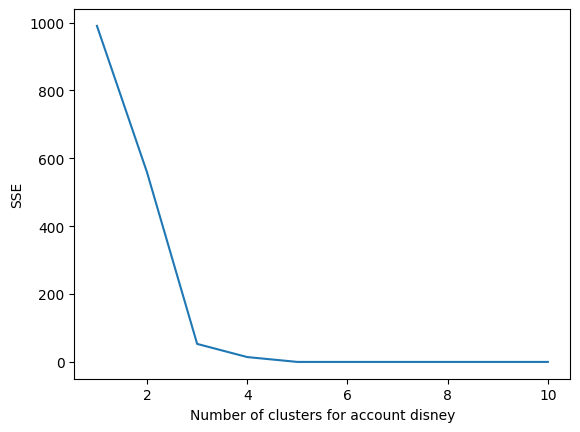

Merchant disney optimal k value is: 4
Processing account: etsy


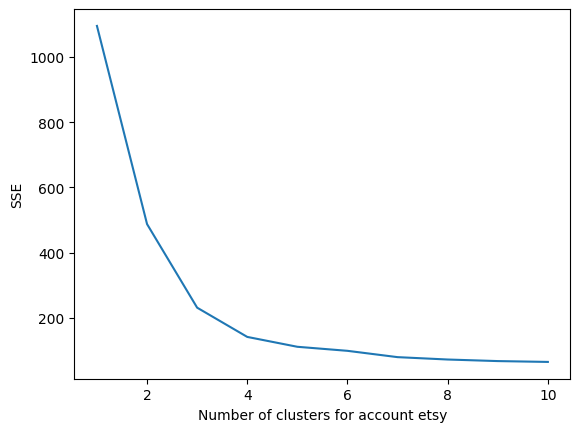

Merchant etsy optimal k value is: 3
Processing account: fat face


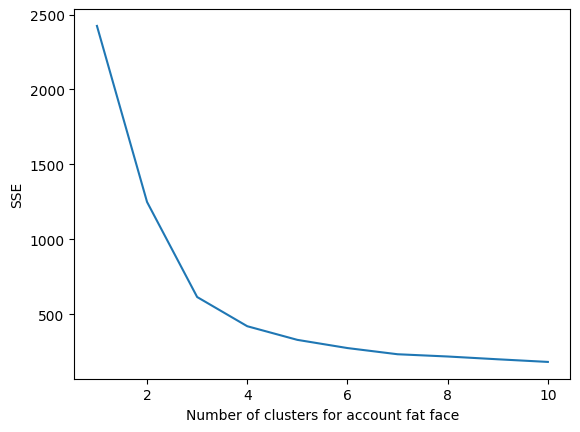

Merchant fat face optimal k value is: 3
Processing account: fitted stitch


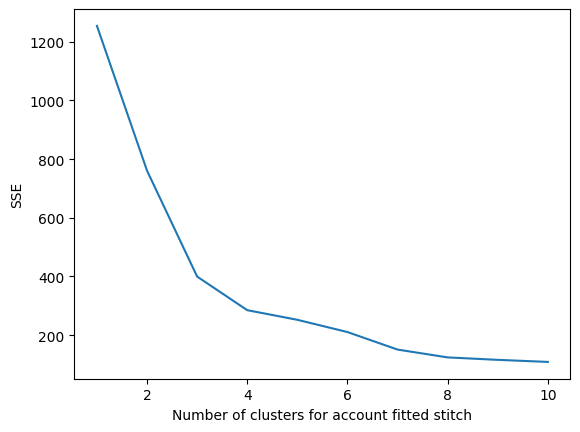

Merchant fitted stitch optimal k value is: 3
Processing account: five senses art


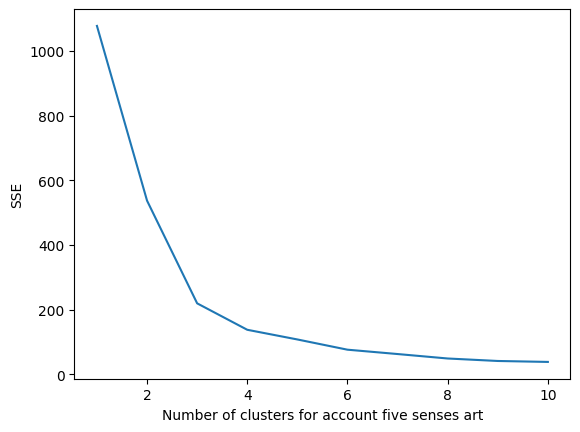

Merchant five senses art optimal k value is: 3
Processing account: foyles


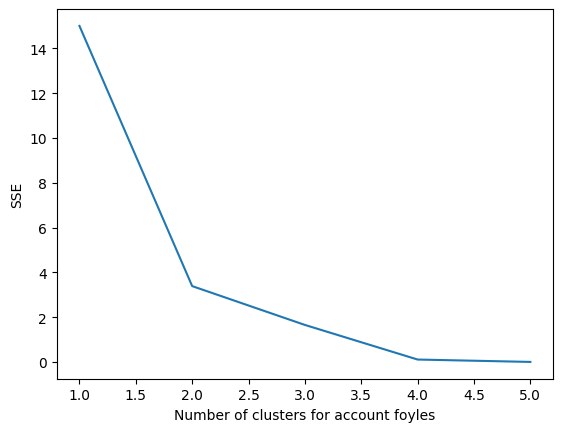

Merchant foyles optimal k value is: 3
Processing account: frankie & bennies


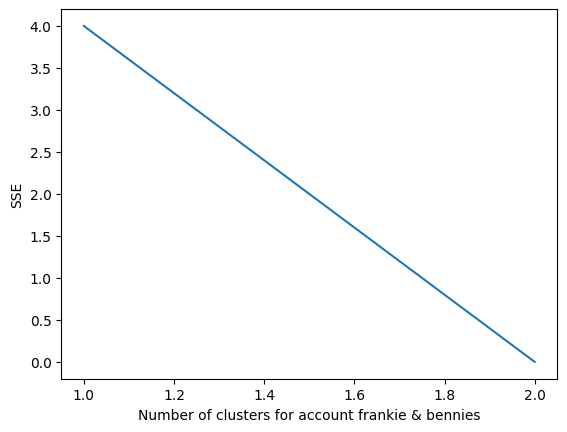

Merchant frankie & bennies optimal k value is: 3
Processing account: gamestation


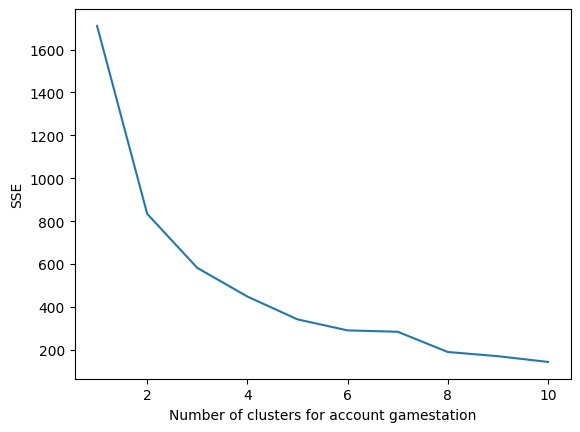

Merchant gamestation optimal k value is: 3
Processing account: gap kids
Not enough unique data points to perform Elbow Method for account gap kids.
Processing account: grand union bjj


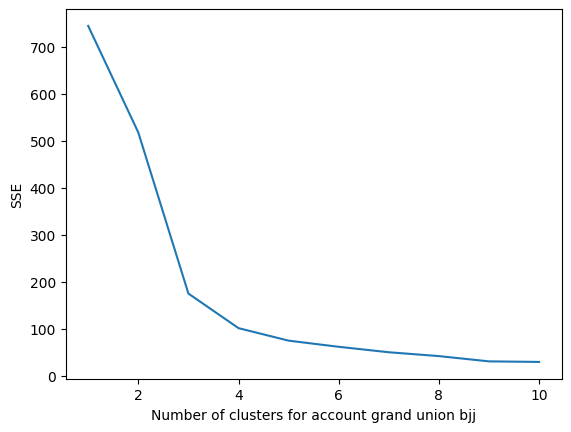

Merchant grand union bjj optimal k value is: 4
Processing account: halifax


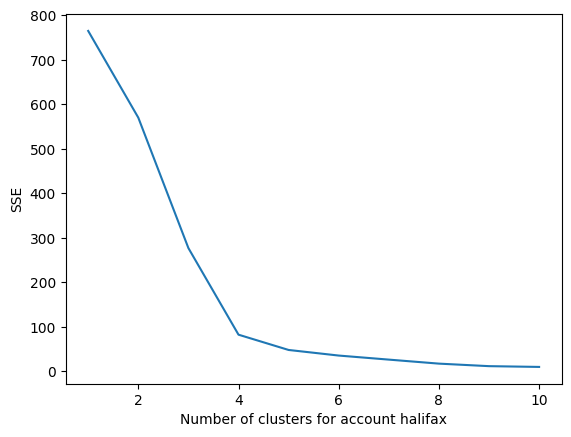

Merchant halifax optimal k value is: 4
Processing account: happy days home
Not enough unique data points to perform Elbow Method for account happy days home.
Processing account: head
Not enough unique data points to perform Elbow Method for account head.
Processing account: hmv
Not enough unique data points to perform Elbow Method for account hmv.
Processing account: hobby lobby


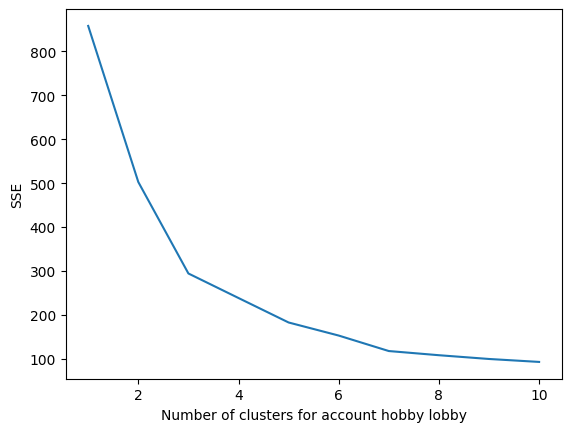

Merchant hobby lobby optimal k value is: 3
Processing account: hobbycraft


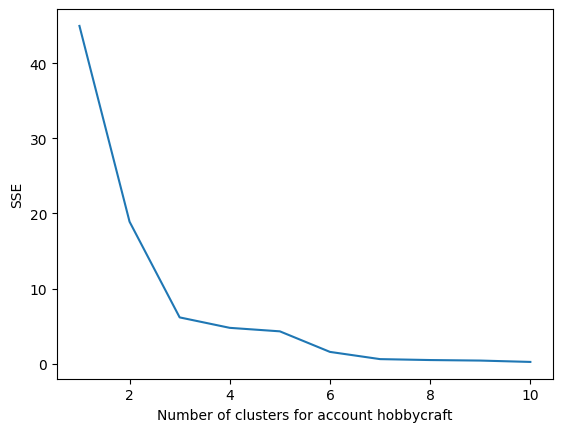

Merchant hobbycraft optimal k value is: 3
Processing account: jd sports


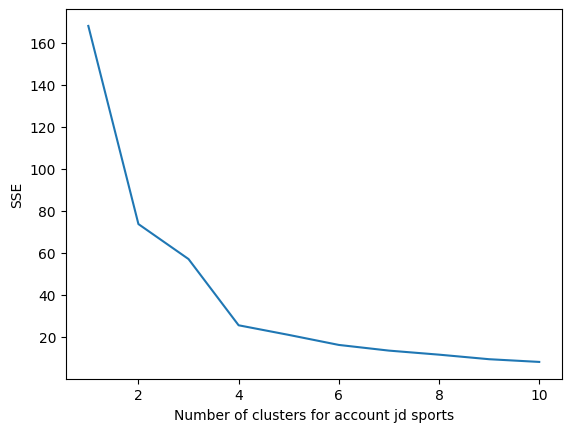

Merchant jd sports optimal k value is: 3
Processing account: justeat


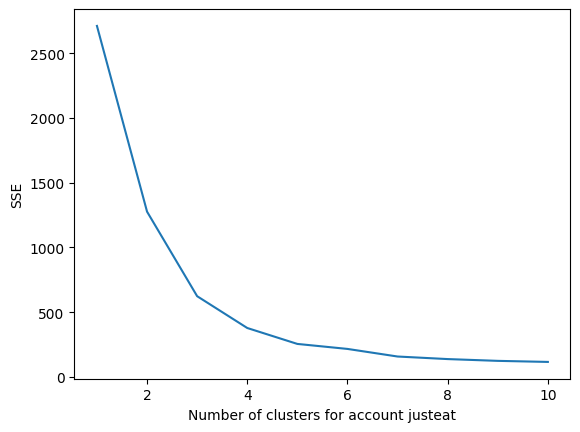

Merchant justeat optimal k value is: 3
Processing account: kew house


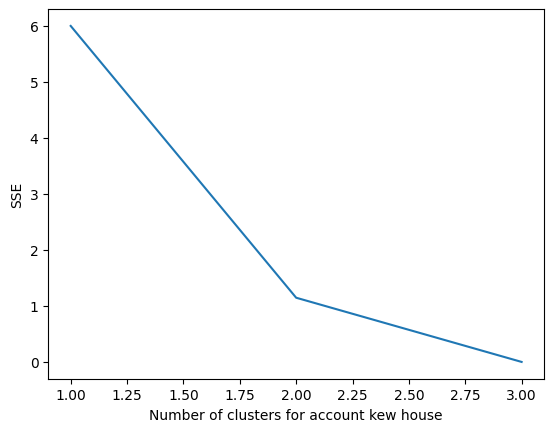

Merchant kew house optimal k value is: 3
Processing account: kings arms


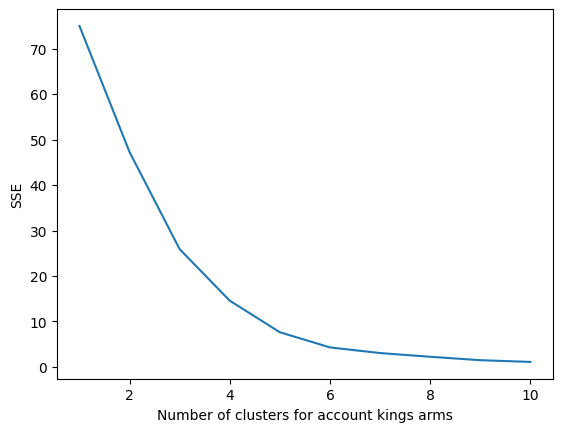

Merchant kings arms optimal k value is: 3
Processing account: lavender primary


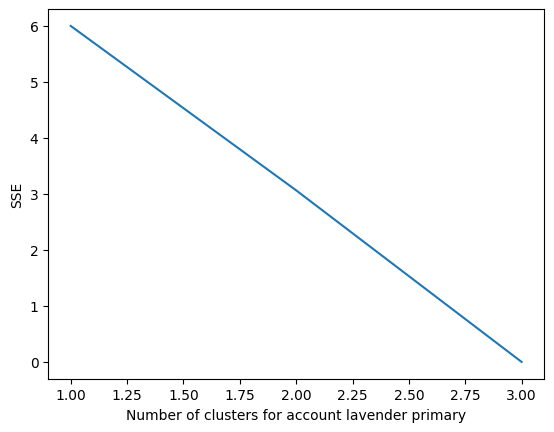

Merchant lavender primary optimal k value is: 4
Processing account: lbg


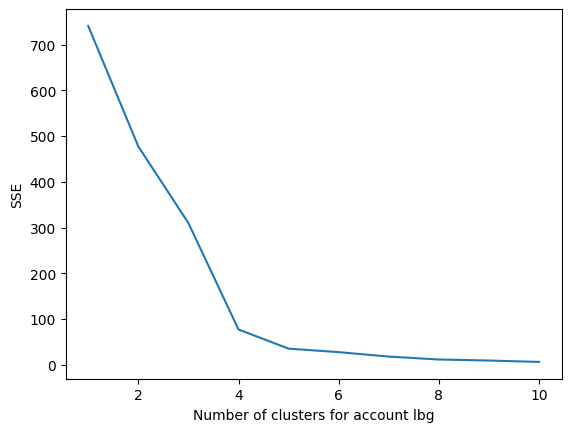

Merchant lbg optimal k value is: 3
Processing account: lloyds pharmacy


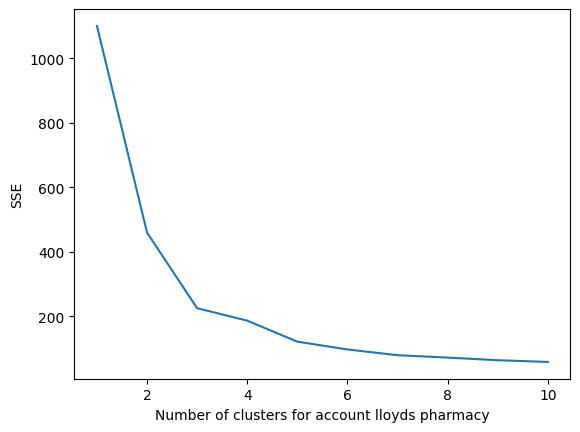

Merchant lloyds pharmacy optimal k value is: 3
Processing account: loosely fitted


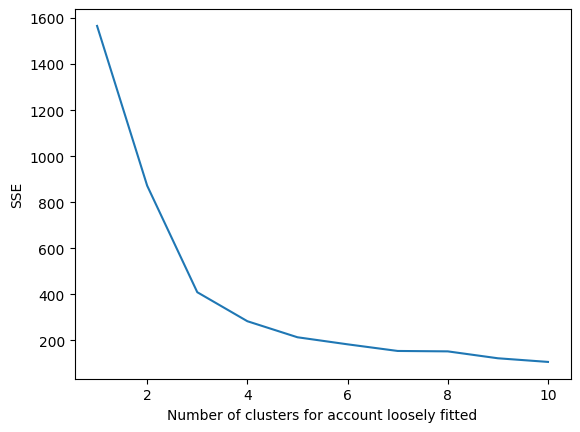

Merchant loosely fitted optimal k value is: 3
Processing account: mamas & papas


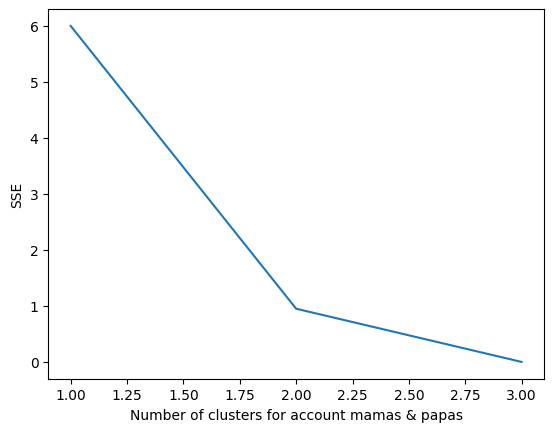

Merchant mamas & papas optimal k value is: 3
Processing account: matalan


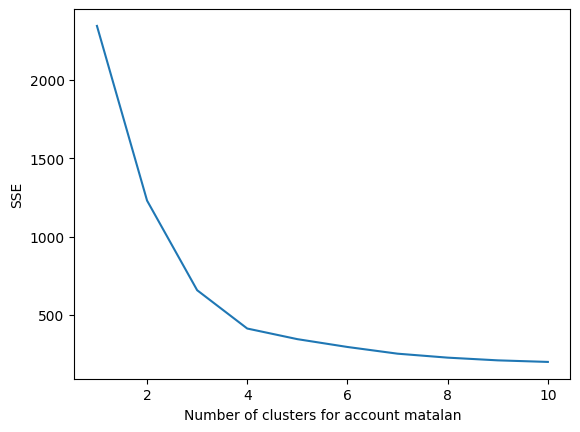

Merchant matalan optimal k value is: 3
Processing account: millets
Not enough unique data points to perform Elbow Method for account millets.
Processing account: mojang studios


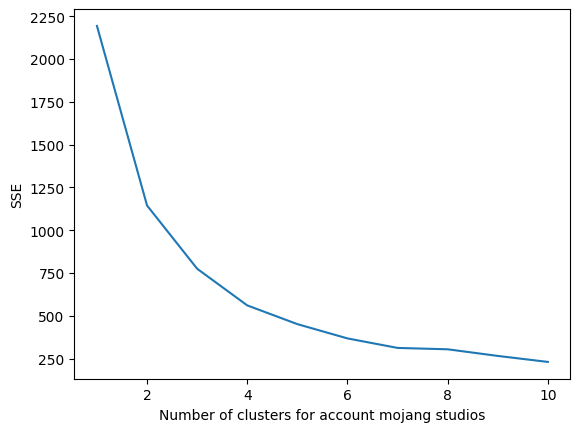

Merchant mojang studios optimal k value is: 3
Processing account: mothercare
Not enough unique data points to perform Elbow Method for account mothercare.
Processing account: mountain warehouse
Not enough unique data points to perform Elbow Method for account mountain warehouse.
Processing account: netflix


D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklear

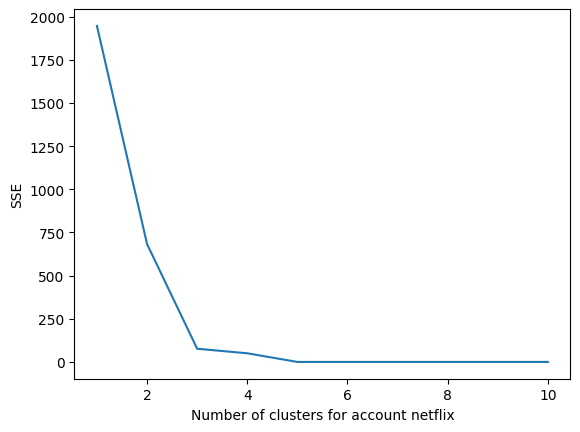

Merchant netflix optimal k value is: 3
Processing account: north face


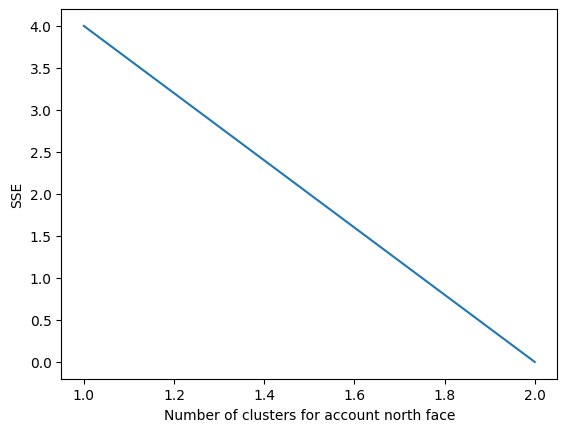

Merchant north face optimal k value is: 3
Processing account: pets corner
Not enough unique data points to perform Elbow Method for account pets corner.
Processing account: puregym


D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
D:\develop\MINI project\lib\site-packages\sklear

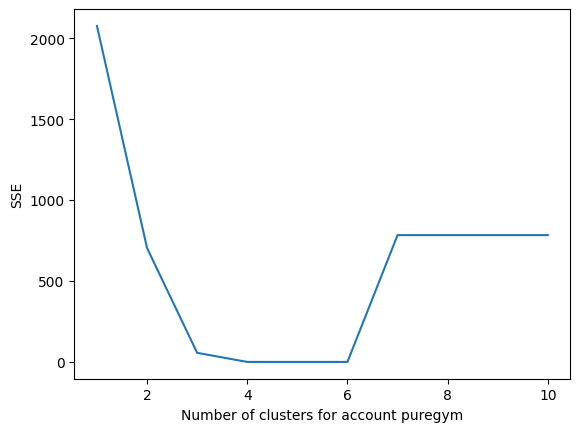

Merchant puregym optimal k value is: 3
Processing account: reebok


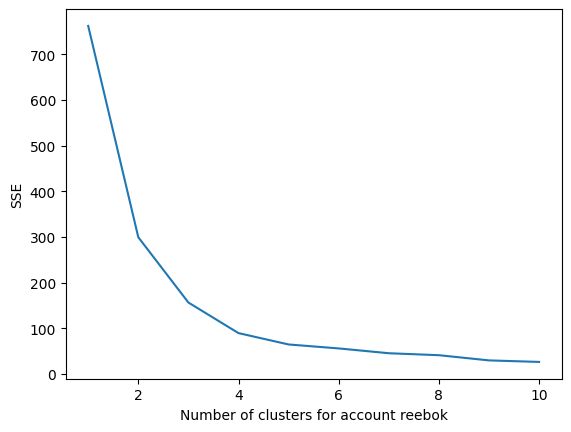

Merchant reebok optimal k value is: 3
Processing account: remedy plus care
Not enough unique data points to perform Elbow Method for account remedy plus care.
Processing account: revella


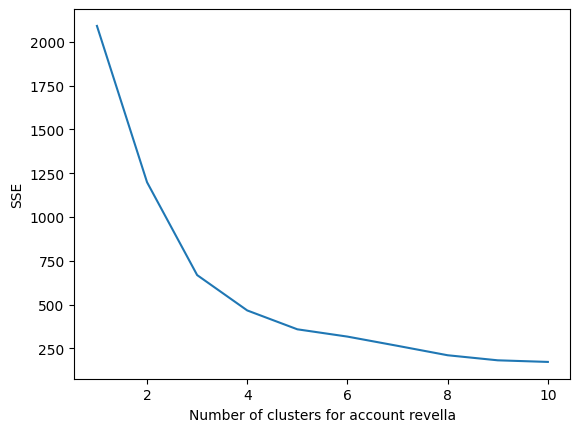

Merchant revella optimal k value is: 3
Processing account: rose & crown


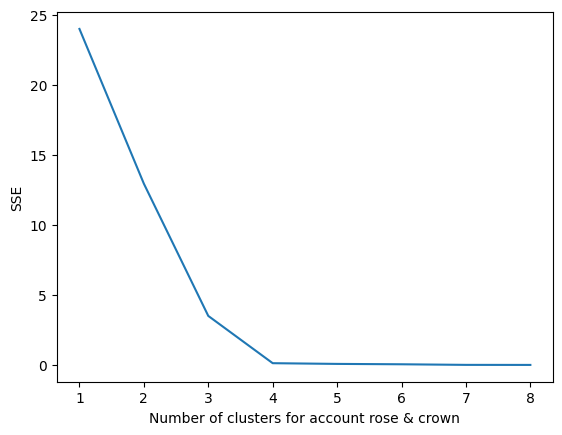

Merchant rose & crown optimal k value is: 3
Processing account: rugbyfields
Not enough unique data points to perform Elbow Method for account rugbyfields.
Processing account: sainsbury


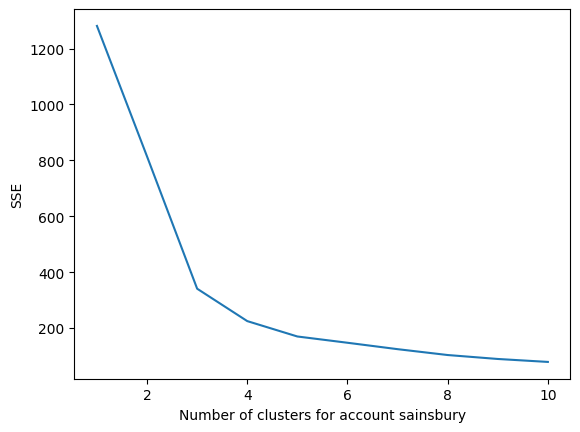

Merchant sainsbury optimal k value is: 4
Processing account: sainsbury local


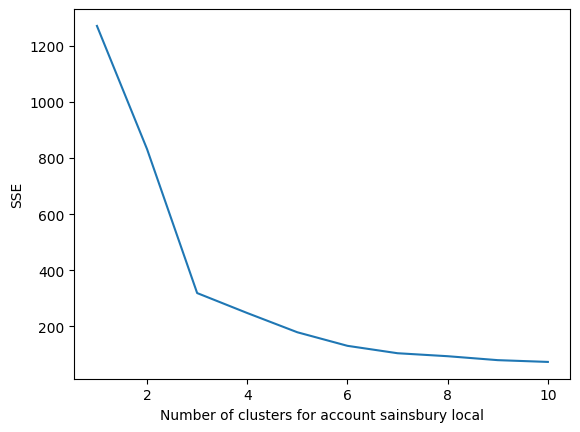

Merchant sainsbury local optimal k value is: 4
Processing account: selfridges


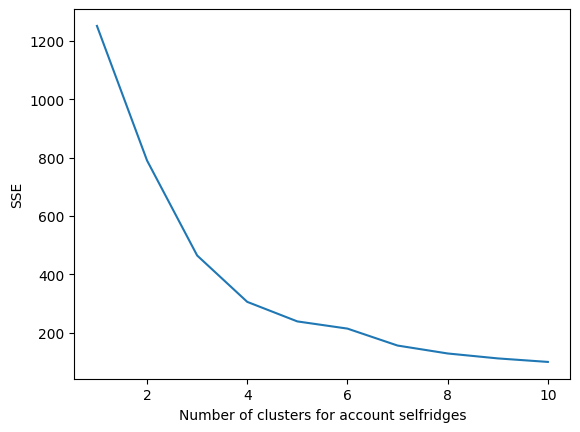

Merchant selfridges optimal k value is: 3
Processing account: specsavers
Not enough unique data points to perform Elbow Method for account specsavers.
Processing account: sports direct


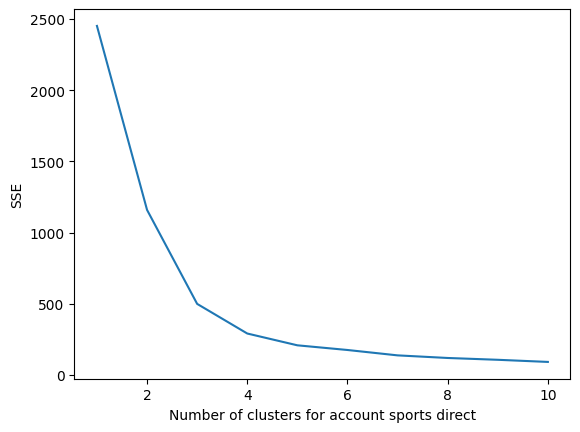

Merchant sports direct optimal k value is: 3
Processing account: squareonix


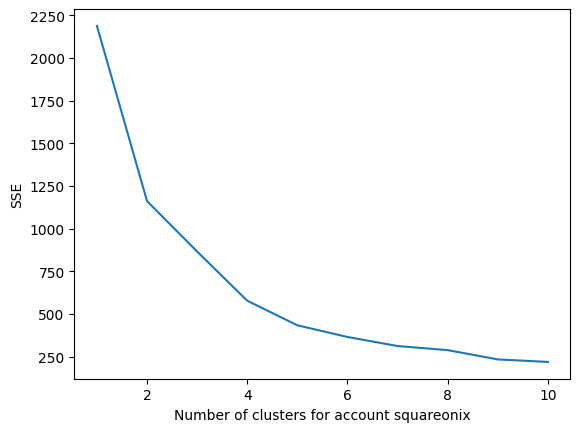

Merchant squareonix optimal k value is: 3
Processing account: starbucks


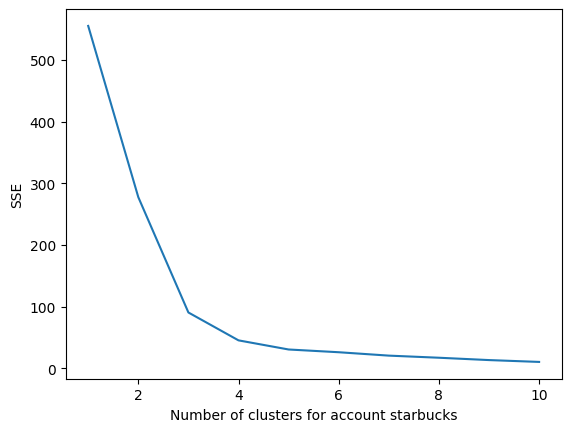

Merchant starbucks optimal k value is: 3
Processing account: stitch by stitch


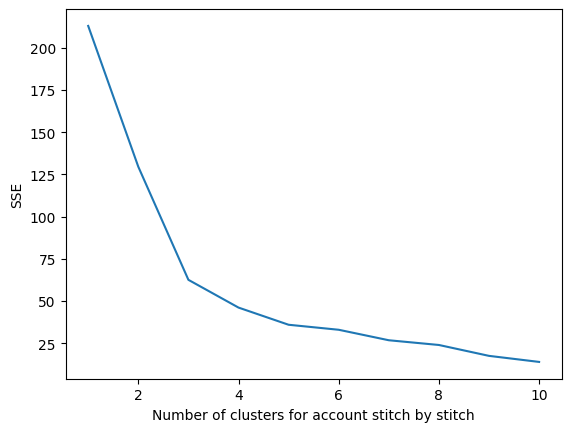

Merchant stitch by stitch optimal k value is: 3
Processing account: tesco


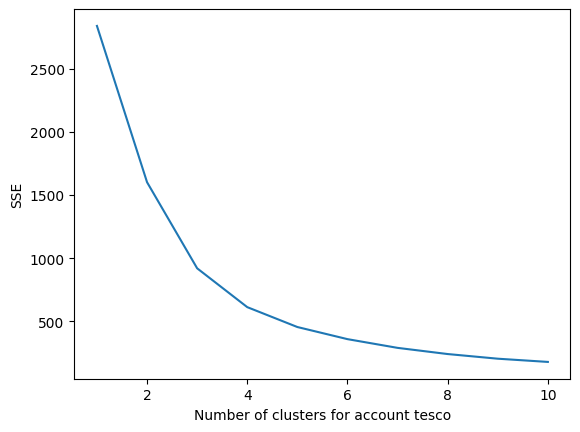

Merchant tesco optimal k value is: 3
Processing account: the crown


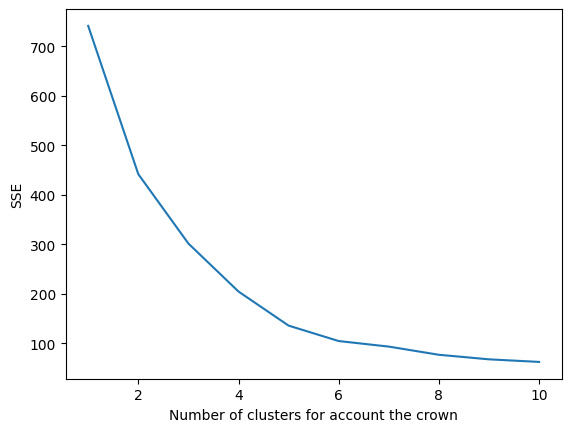

Merchant the crown optimal k value is: 3
Processing account: the works


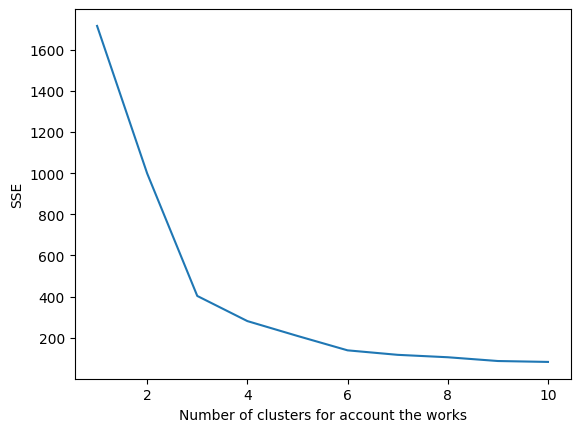

Merchant the works optimal k value is: 3
Processing account: topshop


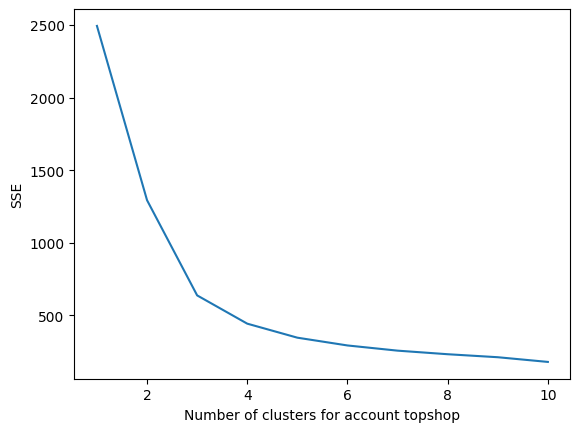

Merchant topshop optimal k value is: 3
Processing account: town high


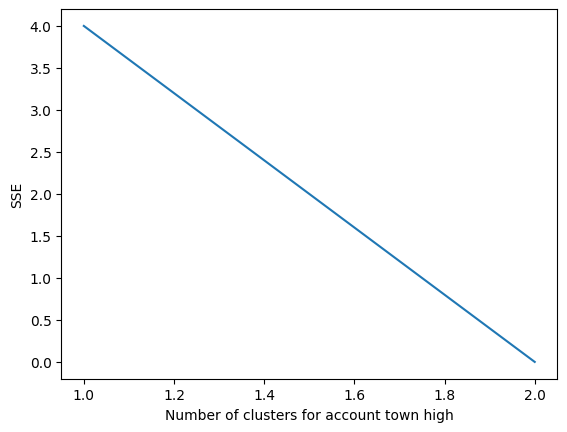

Merchant town high optimal k value is: 3
Processing account: university college hospital
Not enough unique data points to perform Elbow Method for account university college hospital.
Processing account: victoria park
Not enough unique data points to perform Elbow Method for account victoria park.
Processing account: vision express
Not enough unique data points to perform Elbow Method for account vision express.
Processing account: wool


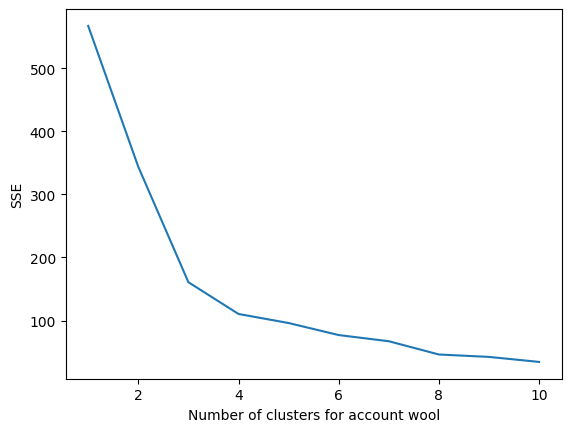

Merchant wool optimal k value is: 3
Processing account: xbox


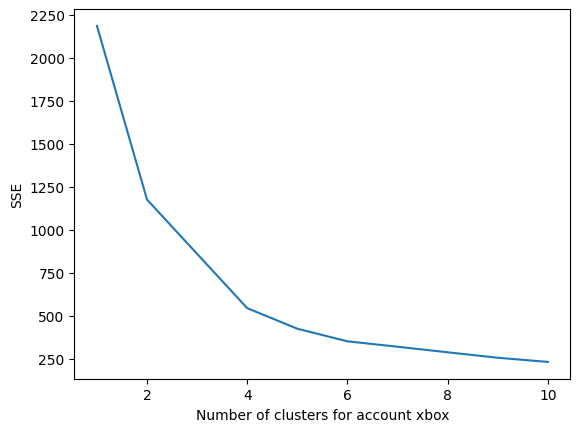

Merchant xbox optimal k value is: 3
3.1403508771929824


In [58]:
best_ks = {}
accounts_to_remove = set()
#Perform independent clustering analysis on each merchant
for account in rfm['Third Party Name'].unique():
    print(f"Processing account: {account}")

#Filter data for specific merchants
    account_rfm2 = rfm[rfm['Third Party Name'] == account]
#Data preprocessing - Standardized RFM values
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(account_rfm2[['recency', 'frequency', 'monetary']])
# rfm_scaled = scaler.fit_transform(rfm2[['recency', 'frequency', 'monetary']])
#Initialize SSE dictionary to store SSE for each k value
    sse = {}
# Use Elbow Method to find the optimal K value and test K values up to the number of samples
    max_k = min(len(account_rfm2), 10)
    if max_k > 1:
        for k in range(1, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(rfm_scaled)
            sse[k] = kmeans.inertia_  # store SSE (Sum of Squared Errors)

        # Draw a graph of SSE changing with the number of clusters
        plt.figure()
        plt.plot(list(sse.keys()), list(sse.values()))
        plt.xlabel(f"Number of clusters for account {account}")
        plt.ylabel("SSE")
        plt.show()
        sse_values = list(sse.values())  # Convert dictionary values to lists
        sse_differences = np.diff(sse_values)  # Calculate the first-order difference of a list
        best_k = np.argmax(-sse_differences) + 2 + 1  # Find the k value corresponding to the maximum
        # negative difference and add 2 because the index starts from 0, while our k value starts from 1. Adding 1 more will result in the final K value
        best_ks[account] = best_k
        # Print out the best k value
        print(f"Merchant {account} optimal k value is: {best_k}")
    else:
        accounts_to_remove.add(account)
        print(f"Not enough unique data points to perform Elbow Method for account {account}.")
mean_best_k = np.mean(list(best_ks.values()))
print(mean_best_k)

rfm = rfm[~rfm['Third Party Name'].isin(accounts_to_remove)]

# k_opt = 3  #This value is the inflection point value in the elbow diagram
# #Applying K-Means clustering
# kmeans = KMeans(n_clusters=k_opt, random_state=42)
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])
# clusters = kmeans.fit_predict(rfm_scaled)
# rfm['Cluster'] = clusters
# rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [87]:
rfm_labels_df = pd.DataFrame()

for third_party_name in rfm['Third Party Name'].unique():

    account_rfm = rfm[rfm['Third Party Name'] == third_party_name]
    if len(account_rfm) < 3:
        continue
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(account_rfm[['recency', 'frequency', 'monetary']])

    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(rfm_scaled)
    centers = np.array(kmeans.cluster_centers_)
    clusters = kmeans.labels_

    unique_clusters = np.unique(clusters)
    if len(unique_clusters) == 3:
        #Searching for clusters with the highest amount as high-value customers
        a = np.argmax(centers[:, 2])
        unique_clusters = np.delete(unique_clusters, a)

        #Identify remaining labels to define developing customers and low value/risk customers
        if centers[unique_clusters[1], 0] <= centers[unique_clusters[0], 0]:
            if centers[unique_clusters[0], 0] == centers[unique_clusters[1], 0]:
                index = int(centers[unique_clusters[1], 2] > centers[unique_clusters[0], 2])
                b = unique_clusters[index]
            else:
                index = 1
                b = unique_clusters[index]
        else:
            index = 0
            b = unique_clusters[index]

        unique_clusters = np.delete(unique_clusters, index)
        c = unique_clusters[0]
        cluster_labels = {a: 'High-Value Customers', b: 'Developing Customers', c: 'Low-Value/Risky Customers'}

    #Some data may only have two labels
    elif len(unique_clusters) == 2:
        a = np.argmax(centers[:, 2])
        unique_clusters = np.delete(unique_clusters, a)
        b = unique_clusters[0]
        cluster_labels = {a: 'High-Value Customers', b: 'Developing Customers'}

    #Some data may only have one label
    elif len(unique_clusters) == 1:
        a = unique_clusters[0]
        cluster_labels = {a: 'Developing Customers'}

    account_rfm_copy = account_rfm.copy()
    account_rfm_copy['cluster'] = clusters
    account_rfm_copy['cluster_label'] = account_rfm_copy['cluster'].map(cluster_labels)
    rfm_labels_df = pd.concat([rfm_labels_df, account_rfm_copy], axis=0, ignore_index=True)

print(rfm_labels_df.head(1000).to_string(index=False))
rfm_labels_df.to_csv('New_dataset_RFM_with_K_means_customer_groups.csv', index=False)

Third Party Name  Account No  recency  frequency  monetary  cluster             cluster_label
    a yarn story   128033695       16         15       293        1      Developing Customers
    a yarn story   138969884      158          1        48        0 Low-Value/Risky Customers
    a yarn story   221868392      319          1         3        0 Low-Value/Risky Customers
    a yarn story   228136274      281          1        33        0 Low-Value/Risky Customers
    a yarn story   235881534      319          1       135        0 Low-Value/Risky Customers
    a yarn story   257633312      159          1         8        0 Low-Value/Risky Customers
    a yarn story   263882093      336          1        38        0 Low-Value/Risky Customers
    a yarn story   270374623       47          2        44        1      Developing Customers
    a yarn story   284161641       96          3       118        1      Developing Customers
    a yarn story   285115279      293          1        11  

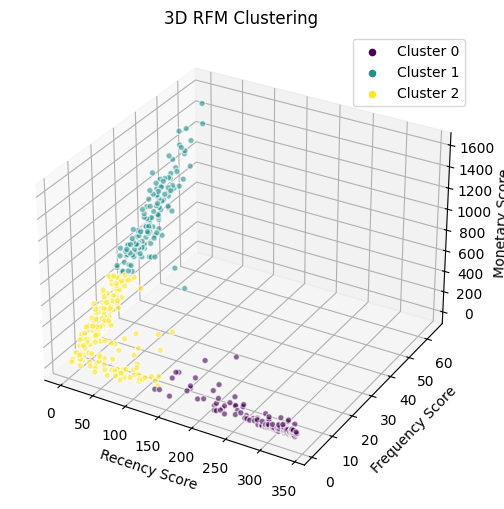

In [83]:
account_rfm = rfm[rfm['Third Party Name'] == rfm['Third Party Name'].unique()[1]]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(account_rfm[['recency', 'frequency', 'monetary']])
rfm_original = scaler.inverse_transform(rfm_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_scaled)
clusters = kmeans.labels_

#Create a new graph and a 3D subgraph
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


#Assign data points to three-dimensional space
xs = rfm_original[:, 0]  # Recency
ys = rfm_original[:, 1]  # Frequency
zs = rfm_original[:, 2]  # Monetary


#Create a 3D scatter plot with colors defined by clustering labels
scatter = ax.scatter(xs, ys, zs, c=clusters, cmap='viridis', marker='o', alpha=0.6, edgecolors='w')


 #Set chart titles and axis labels
ax.set_title('3D RFM Clustering')
ax.set_xlabel('Recency Score')
ax.set_ylabel('Frequency Score')
ax.set_zlabel('Monetary Score')

colors = [scatter.cmap(a) for a in np.linspace(0, 1, len(np.unique(clusters)))]
labels = [f'Cluster {i}' for i in np.unique(clusters)]
for color, label in zip(colors, labels):
    ax.scatter([], [], [], color=color, label=label)

ax.legend()
ax.legend()
plt.show()

In [85]:
filtered_df = grouped2[
    (grouped2['Account No'] ==  932820758) &
    (grouped2['Third Party Name'] == 'disney')
]

# Now we can calculate the total money spent, the number of visits, and the date of the last visit.
total_money_spent = -filtered_df['Amount'].sum()
number_of_visits = filtered_df.shape[0]
date_of_last_visit = filtered_df['Datetime'].max()
last_balance = filtered_df.sort_values(by='Datetime', ascending=False).iloc[0]['Balance']
total_money_spent, number_of_visits, date_of_last_visit,last_balance

(95.87999999999998, 12, Timestamp('2023-11-30 23:59:00'), -2805.726566775553)

In [88]:
high_value_customers = rfm_labels_df[rfm_labels_df['cluster_label'] == 'High-Value Customers']
last_balance = grouped2.sort_values(by=['Account No', 'Datetime'])\
                       .drop_duplicates(subset=['Account No'], keep='last')\
                       [['Account No', 'Balance']]
high_value_customers = high_value_customers.merge(last_balance, on=[ 'Account No'], how='left')
#Mapping labels to cluster numbers in DataFrame
rfm_Kmeans = high_value_customers[[ 'Third Party Name', 'Account No', 'cluster', 'cluster_label', 'Balance']]
print(rfm_Kmeans.head(10000).to_string(index=False))
rfm_Kmeans.to_csv('New_dataset_high_value_customers.csv', index=False)

 Third Party Name  Account No  cluster        cluster_label  Balance
     a yarn story   441142605        2 High-Value Customers     2472
     a yarn story   779376323        2 High-Value Customers     5008
           amazon   108481285        1 High-Value Customers    10704
           amazon   108563213        1 High-Value Customers    26334
           amazon   113747882        1 High-Value Customers    13639
           amazon   116598243        1 High-Value Customers     3634
           amazon   128033695        1 High-Value Customers     2626
           amazon   145387690        1 High-Value Customers     6198
           amazon   146909202        1 High-Value Customers     4562
           amazon   151968462        1 High-Value Customers     8946
           amazon   169006407        1 High-Value Customers    13235
           amazon   170637730        1 High-Value Customers     1772
           amazon   176922958        1 High-Value Customers     2361
           amazon   179173981     

In [89]:
#Screen out high-value customers
high_value_customers = rfm_labels_df[rfm_labels_df['cluster_label'] == 'High-Value Customers']

#Calculate the number of times each account appears as a high-value customer and convert it into a DataFrame
high_value_counts_df = high_value_customers['Account No'].value_counts().reset_index()
high_value_counts_df.columns = ['Account No', 'High_Value_Counts']

#Merge the count information back into the original DataFrame to obtain additional information for each account
high_value_counts_merged = high_value_customers.merge(high_value_counts_df, on='Account No')

#Remove duplicate account information as we only need to display each account once
high_value_counts_merged.drop_duplicates(subset='Account No', inplace=True)

#Sort high-value customers in reverse order of frequency
high_value_counts_sorted = high_value_counts_merged.sort_values(by='High_Value_Counts', ascending=False)


print(high_value_counts_sorted[['Account No', 'High_Value_Counts']].head(900).to_string(index=False))
print(np.mean(high_value_counts_sorted['High_Value_Counts']))


 Account No  High_Value_Counts
  549414742                 18
  547010927                 17
  940569402                 15
  203466392                 15
  806358207                 14
  522188082                 14
  858989281                 14
  489964679                 14
  256002321                 13
  506618547                 13
  987656636                 13
  851649498                 13
  322221939                 13
  441274121                 13
  749378808                 13
  433917275                 13
  331450202                 13
  541639148                 12
  949032480                 12
  905860285                 12
  518474507                 12
  519644021                 12
  310375875                 12
  572384506                 12
  399144202                 12
  146909202                 12
  604288474                 12
  213112754                 12
  679662108                 11
  853907490                 11
  124102251                 11
  480557

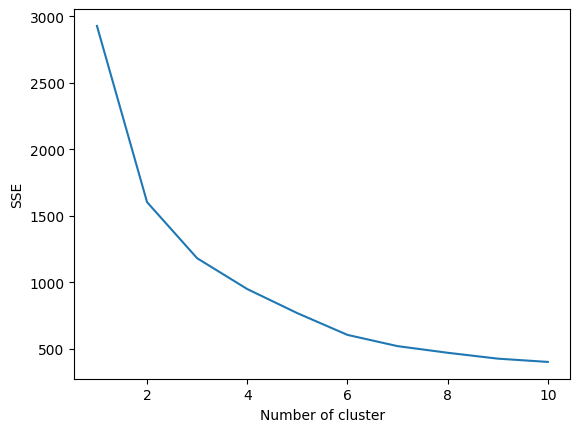

In [90]:
rfm2 = grouped2.groupby([ 'Account No']).agg({
    'Datetime': lambda x: (current_date - x.max()).days,  # Recency
    'Account No': 'count',                                        # Frequency
    'Amount': lambda x: -x.sum()                                    # Monetary
}).rename(columns={
    'Datetime': 'recency',
    'Account No': 'frequency',
    'Amount': 'monetary'
}).reset_index()

scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(account_rfm[['r_score', 'f_score', 'm_score']])
rfm_scaled2 = scaler.fit_transform(rfm2[['recency', 'frequency', 'monetary']])
#Initialize SSE dictionary to store SSE for each k value
sse = {}

#Use Elbow Method to find the optimal K value and test K values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled2)
    sse[k] = kmeans.inertia_  # 存储SSE (Sum of Squared Errors)

#Draw a graph of SSE changing with k value
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel(f"Number of cluster for account {account}")
plt.xlabel(f"Number of cluster")
plt.ylabel("SSE")
plt.show()

# Select the optimal K value based on the graph

k_opt = 3  #This value is the inflection point value in the elbow diagram

#Applying K-Means clustering
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled2)
rfm2['Cluster'] = clusters

rfm2['Cluster'] = kmeans.fit_predict(rfm_scaled2)

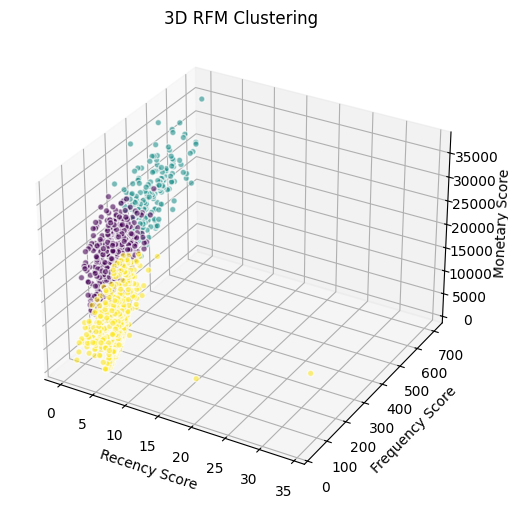

In [91]:
rfm_original = scaler.inverse_transform(rfm_scaled2)

#Create a new graph and a 3D subgraph
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#Assign data points to three-dimensional space
xs = rfm_original[:, 0]  # Recency
ys = rfm_original[:, 1]  # Frequency
zs = rfm_original[:, 2]  # Monetary

#Create a 3D scatter plot with colors defined by clustering labels
scatter = ax.scatter(xs, ys, zs, c=clusters, cmap='viridis', marker='o', alpha=0.6, edgecolors='w')

#Set chart titles and axis labels
ax.set_title('3D RFM Clustering')
ax.set_xlabel('Recency Score')
ax.set_ylabel('Frequency Score')
ax.set_zlabel('Monetary Score')

plt.show()

In [92]:
#Define clustering labels
cluster_labels = {
    1: 'High-Value Customers',
    0: 'Developing Customers',
    2: 'Low-Value/Risky Customers'
}
last_balance = grouped2.sort_values(by=['Account No', 'Datetime'])\
                       .drop_duplicates(subset=['Account No'], keep='last')\
                       [['Account No', 'Balance']]
rfm2 = rfm2.merge(last_balance, on=[ 'Account No'], how='left')
#Mapping labels to cluster numbers in DataFrame
rfm2['Cluster_Label'] = rfm2['Cluster'].map(cluster_labels)
rfm_Kmeans = rfm2[[ 'Account No', 'Cluster', 'Cluster_Label', 'Balance']]
print(rfm_Kmeans.head(1000).to_string(index=False))
rfm_Kmeans.to_csv('New_dataset_RFM_with_K_means_bank_groups2.csv', index=False)

 Account No  Cluster             Cluster_Label  Balance
  101531259        0      Developing Customers      228
  104832000        0      Developing Customers    -3186
  105375973        2 Low-Value/Risky Customers      509
  106601471        0      Developing Customers    11920
  108481285        0      Developing Customers    10704
  108563213        1      High-Value Customers    26334
  108812033        0      Developing Customers      717
  108931112        1      High-Value Customers    16503
  111137699        2 Low-Value/Risky Customers      -80
  113747882        1      High-Value Customers    13639
  116169597        0      Developing Customers     1790
  116598243        1      High-Value Customers     3634
  117273481        1      High-Value Customers    10922
  117308635        0      Developing Customers     2176
  119943495        2 Low-Value/Risky Customers    -1348
  119993184        0      Developing Customers    -2235
  120634201        0      Developing Customers  

In [73]:
filtered_df = grouped2[
    (grouped2['Account No'] ==  128033695)
]

# Now we can calculate the total money spent, the number of visits, and the date of the last visit.
total_money_spent = -filtered_df['Amount'].sum()
number_of_visits = filtered_df.shape[0]
date_of_last_visit = filtered_df['Datetime'].max()
last_balance = filtered_df.sort_values(by='Datetime', ascending=False).iloc[0]['Balance']
total_money_spent, number_of_visits, date_of_last_visit,last_balance

(13044.44, 408, Timestamp('2023-12-06 18:37:00'), 2625.9024201137545)

In [93]:
high_value_customers2 = rfm_Kmeans[rfm_Kmeans['Cluster_Label'] == 'High-Value Customers']
print(high_value_customers2.head(1000).to_string(index=False))
balance_mean = high_value_customers2['Balance'].mean()
print(balance_mean)
high_value_customers2.to_csv('New_dataset_high_value_account.csv', index=False)

 Account No  Cluster        Cluster_Label  Balance
  108563213        1 High-Value Customers    26334
  108931112        1 High-Value Customers    16503
  113747882        1 High-Value Customers    13639
  116598243        1 High-Value Customers     3634
  117273481        1 High-Value Customers    10922
  124102251        1 High-Value Customers     1274
  128033695        1 High-Value Customers     2626
  131388684        1 High-Value Customers    24810
  145387690        1 High-Value Customers     6198
  146909202        1 High-Value Customers     4562
  151968462        1 High-Value Customers     8946
  166019891        1 High-Value Customers     9482
  169006407        1 High-Value Customers    13235
  170637730        1 High-Value Customers     1772
  179173981        1 High-Value Customers     4459
  183888402        1 High-Value Customers    20811
  187111705        1 High-Value Customers     7678
  187541224        1 High-Value Customers     2774
  195895574        1 High-Value